# 🧠 Memory Systems - A Memória que Faltava na sua IA!

**Módulo 7 de 17 - LangChain v0.3**

Eai pessoal! Tudo certo? 🚀

Até agora a gente viu Chains, Prompts, OutputParsers... mas cara, tem um problemão! Toda vez que você faz uma pergunta pro seu modelo, ele esquece completamente da conversa anterior. É como se você tivesse um amigo com amnésia total!

**Tá, mas o que é Memory System mesmo?**

É literalmente dar memória pro seu chatbot! Imagina que você tá conversando com alguém e a pessoa esquece seu nome a cada 2 minutos... chato né? É exatamente isso que acontece sem Memory Systems.

Bora resolver isso! 🔥

## 🎯 O que vamos aprender hoje?

1. **Por que precisamos de memória?** (spoiler: LLMs são meio "esquecidos")
2. **Tipos de Memory no LangChain**
3. **ConversationBufferMemory** - A mais simples
4. **ConversationSummaryMemory** - Quando a conversa fica longa
5. **ConversationBufferWindowMemory** - Memória com "janela"
6. **Implementando na prática**
7. **Preparando pro RAG** (módulo 10)

**Dica!** Memória vai ser FUNDAMENTAL quando a gente chegar no RAG e nos Agents!

In [17]:
# Setup inicial - Bora instalar o que precisamos!
!pip install langchain langchain-google-genai python-dotenv matplotlib -q
!pip install -U langchain-community

import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

# Carregando variáveis de ambiente
load_dotenv()

print("✅ Tudo instalado! Bora pro próximo passo!")

✅ Tudo instalado! Bora pro próximo passo!


In [18]:
# Configurando o modelo que vamos usar (nosso querido Gemini!)
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage, AIMessage

# Usando o Gemini 2.0 Flash (como vimos no módulo 2)
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key="SUA_CHAVE_AQUI",
    temperature=0.7
)

print("🤖 Modelo configurado! Vamos testar sem memória primeiro...")

# Teste simples sem memória
response1 = model.invoke("Oi! Meu nome é João")
print(f"Resposta 1: {response1.content}")

response2 = model.invoke("Qual é o meu nome?")
print(f"\nResposta 2: {response2.content}")

print("\n😅 Viu só? Ele esqueceu seu nome! É por isso que precisamos de memória!")

🤖 Modelo configurado! Vamos testar sem memória primeiro...
Resposta 1: Olá, João! É um prazer te conhecer. Meu nome é Assistente. Em que posso te ajudar hoje? 😊

Resposta 2: Como sou um modelo de linguagem, não tenho nome. Você pode se referir a mim como Gemini.

😅 Viu só? Ele esqueceu seu nome! É por isso que precisamos de memória!


## 🧩 Entendendo o Problema

**Tá, mas por que isso acontece?**

Os LLMs (Large Language Models) são **stateless** - isso significa que eles não guardam nada entre as conversas. É como se você ligasse pro atendimento e a cada pergunta te transferissem pra uma pessoa diferente que não sabe de nada!

### Como funciona sem memória:

```
Você: "Oi, meu nome é João"
IA: "Olá João! Como posso ajudar?"

Você: "Qual meu nome?"
IA: "Desculpe, não sei seu nome" 🤦‍♂️
```

### Como funciona COM memória:

```
Você: "Oi, meu nome é João"
IA: "Olá João! Como posso ajudar?"
[MEMÓRIA SALVA: Usuario se chama João]

Você: "Qual meu nome?"
IA: "Seu nome é João!" ✅
```

**Dica!** A memória no LangChain funciona como um "caderninho" que vai anotando toda a conversa!

## 📚 Tipos de Memory no LangChain

O LangChain tem vários tipos de memória, cada um pra uma situação:

### 1. **ConversationBufferMemory** 📝
- Guarda TODA a conversa
- Simples e direta
- Problema: Pode ficar muito longa

### 2. **ConversationSummaryMemory** 🗞️
- Resume conversas longas
- Economiza tokens
- Ideal pra conversas extensas

### 3. **ConversationBufferWindowMemory** 🪟
- Mantém apenas as últimas N mensagens
- Tipo "memória de peixinho"
- Boa pra conversas focadas

### 4. **ConversationSummaryBufferMemory** 🎯
- Combina resumo + buffer
- A mais sofisticada

**Analogia:** É como escolher entre um caderno completo, um resumo do caderno, ou só as últimas páginas!

**Dica!** Vamos começar pela mais simples e ir evoluindo!

📦 Imports feitos! Agora vamos ver cada tipo na prática...


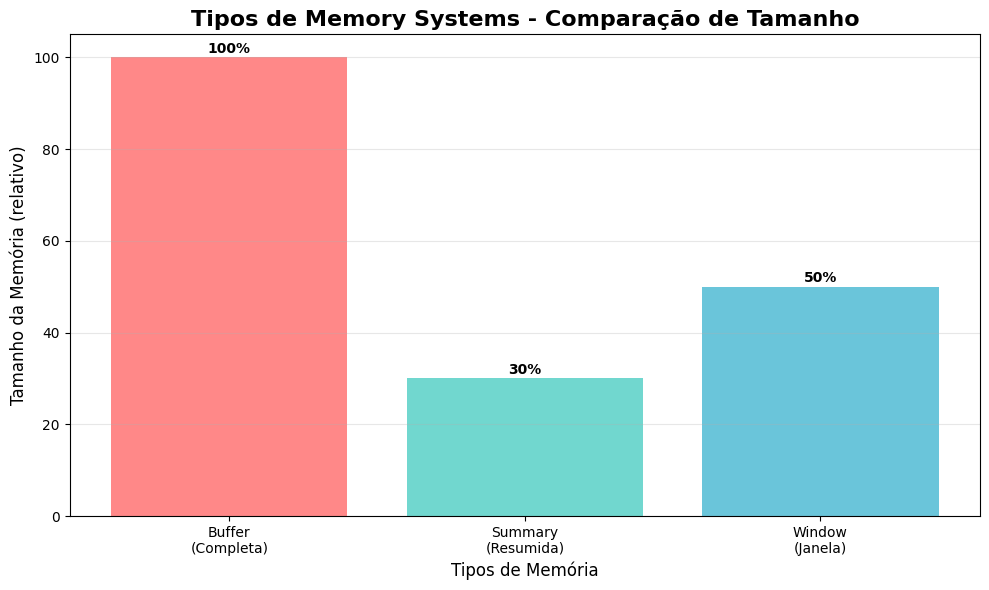

📊 Cada tipo tem seu uso específico! Vamos testar cada um...


In [19]:
# Importando as memórias que vamos usar
from langchain.memory import (
    ConversationBufferMemory,
    ConversationSummaryMemory,
    ConversationBufferWindowMemory
)
from langchain.chains import ConversationChain

print("📦 Imports feitos! Agora vamos ver cada tipo na prática...")

# Visualizando os tipos de memória
memory_types = ['Buffer\n(Completa)', 'Summary\n(Resumida)', 'Window\n(Janela)']
memory_sizes = [100, 30, 50]  # Tamanho relativo da memória
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(10, 6))
bars = plt.bar(memory_types, memory_sizes, color=colors, alpha=0.8)
plt.title('Tipos de Memory Systems - Comparação de Tamanho', fontsize=16, fontweight='bold')
plt.ylabel('Tamanho da Memória (relativo)', fontsize=12)
plt.xlabel('Tipos de Memória', fontsize=12)

# Adicionando valores nas barras
for bar, size in zip(bars, memory_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{size}%', ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Cada tipo tem seu uso específico! Vamos testar cada um...")

## 🎯 ConversationBufferMemory - A Básica

**Tá, mas como funciona a Buffer Memory?**

É bem simples! Ela salva literalmente TUDO que foi falado. Imagina um gravador que nunca para de gravar.

### Estrutura da Buffer Memory:

$$\text{Memory} = \{\text{Human}_1, \text{AI}_1, \text{Human}_2, \text{AI}_2, ..., \text{Human}_n, \text{AI}_n\}$$

Onde cada par (Human, AI) é uma interação completa.

**Vantagens:**
- ✅ Contexto completo
- ✅ Fácil de implementar
- ✅ Nada se perde

**Desvantagens:**
- ❌ Pode ficar muito longa
- ❌ Cara em tokens
- ❌ Pode passar do limite do modelo

**Dica!** Use quando você tem conversas curtas ou quando o contexto completo é crucial!

In [20]:
# Criando nossa primeira memória - ConversationBufferMemory
buffer_memory = ConversationBufferMemory()

# Criando uma chain com memória (lembra das chains do módulo 6?)
conversation_chain = ConversationChain(
    llm=model,
    memory=buffer_memory,
    verbose=True  # Pra ver o que tá rolando por baixo dos panos
)


print("🎉 Chain com memória criada! Bora testar...")

# Teste 1 - Apresentação
response1 = conversation_chain.predict(input="Oi! Meu nome é Pedro e eu sou instrutor de IA")
print(f"\n🤖 Resposta 1: {response1}")

# Teste 2 - Pergunta sobre a informação anterior
response2 = conversation_chain.predict(input="Qual é meu nome e minha profissão?")
print(f"\n🤖 Resposta 2: {response2}")

print("\n🎯 Liiindo! Agora ele lembra! Vamos ver o que tem na memória...")

🎉 Chain com memória criada! Bora testar...


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Oi! Meu nome é Pedro e eu sou instrutor de IA
AI:

> Finished chain.

🤖 Resposta 1: Oi Pedro! É um prazer te conhecer! Meu nome não é bem um nome, mas pode me chamar de Gemini. Eu sou um modelo de linguagem grande, treinado pelo Google. É legal saber que você é um instrutor de IA! Qual tipo de IA você ensina? Eu aprendo muito sobre diferentes áreas de IA durante meu treinamento, desde aprendizado supervisionado e não supervisionado até aprendizado por reforço e processamento de linguagem natural. Talvez você possa me dar algumas dicas! Estou sempre querendo aprender mais. :)


> Entering new ConversationChain chain...


In [21]:
# Investigando o que tem dentro da memória
print("🔍 O que tem na memória Buffer:")
print("=" * 50)
print(buffer_memory.buffer)
print("=" * 50)

# Vamos ver as variáveis da memória também
print("\n📝 Variáveis da memória:")
memory_variables = buffer_memory.load_memory_variables({})
print(memory_variables)

# Adicionando mais uma interação pra ver como cresce
response3 = conversation_chain.predict(input="Quais são suas linguagens de programação favoritas?")
print(f"\n🤖 Resposta 3: {response3}")

print("\n📈 Vamos ver como a memória cresceu:")
print("=" * 50)
print(buffer_memory.buffer)
print("=" * 50)

🔍 O que tem na memória Buffer:
Human: Oi! Meu nome é Pedro e eu sou instrutor de IA
AI: Oi Pedro! É um prazer te conhecer! Meu nome não é bem um nome, mas pode me chamar de Gemini. Eu sou um modelo de linguagem grande, treinado pelo Google. É legal saber que você é um instrutor de IA! Qual tipo de IA você ensina? Eu aprendo muito sobre diferentes áreas de IA durante meu treinamento, desde aprendizado supervisionado e não supervisionado até aprendizado por reforço e processamento de linguagem natural. Talvez você possa me dar algumas dicas! Estou sempre querendo aprender mais. :)
Human: Qual é meu nome e minha profissão?
AI: Seu nome é Pedro e você é um instrutor de IA! :)

📝 Variáveis da memória:
{'history': 'Human: Oi! Meu nome é Pedro e eu sou instrutor de IA\nAI: Oi Pedro! É um prazer te conhecer! Meu nome não é bem um nome, mas pode me chamar de Gemini. Eu sou um modelo de linguagem grande, treinado pelo Google. É legal saber que você é um instrutor de IA! Qual tipo de IA você ensi

## 🗞️ ConversationSummaryMemory - A Inteligente

**E quando a conversa fica muito longa?**

Aí que entra a Summary Memory! Ao invés de guardar tudo palavra por palavra, ela vai fazendo um resumo da conversa. É como ter uma secretária que vai anotando só o importante!

### Como funciona:

1. **Conversa acontece** 💬
2. **IA resume o que foi dito** 📄
3. **Próxima pergunta usa o resumo** 🔄

### Fórmula da Summary Memory:

$$\text{Summary}_{n+1} = \text{Summarize}(\text{Summary}_n + \text{New Interaction})$$

**Vantagens:**
- ✅ Economiza tokens
- ✅ Não estoura limite do modelo
- ✅ Mantém informações importantes

**Desvantagens:**
- ❌ Pode perder detalhes
- ❌ Gasta tokens pra fazer resumo
- ❌ Resumo pode não ser perfeito

**Dica!** Ideal pra conversas longas onde você precisa do contexto geral, mas não de cada palavra!

In [22]:
# Criando Summary Memory
summary_memory = ConversationSummaryMemory(
    llm=model,  # Precisa do modelo pra fazer os resumos
    return_messages=True
)

# Chain com summary memory
summary_chain = ConversationChain(
    llm=model,
    memory=summary_memory,
    verbose=True
)

print("📄 Summary Memory criada! Vamos simular uma conversa longa...")

# Simulando várias interações
interactions = [
    "Oi! Sou Maria, tenho 30 anos e trabalho como desenvolvedora Python em São Paulo",
    "Estou aprendendo IA e machine learning há 6 meses",
    "Meu projeto atual é um sistema de recomendação para e-commerce",
    "Uso principalmente scikit-learn e tensorflow no meu trabalho",
    "Qual é meu nome, idade e em que cidade trabalho?"
]

responses = []
for i, interaction in enumerate(interactions):
    response = summary_chain.predict(input=interaction)
    responses.append(response)
    print(f"\n🔄 Interação {i+1}:")
    print(f"Você: {interaction}")
    print(f"IA: {response[:100]}...")

print("\n🎯 Vamos ver o resumo que foi criado!")

📄 Summary Memory criada! Vamos simular uma conversa longa...


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[SystemMessage(content='', additional_kwargs={}, response_metadata={})]
Human: Oi! Sou Maria, tenho 30 anos e trabalho como desenvolvedora Python em São Paulo
AI:

> Finished chain.

🔄 Interação 1:
Você: Oi! Sou Maria, tenho 30 anos e trabalho como desenvolvedora Python em São Paulo
IA: Oi Maria! Prazer em te conhecer! É muito legal saber que você trabalha como desenvolvedora Python em...


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI d

In [23]:
# Investigando o resumo criado
print("📋 Resumo da conversa:")
print("=" * 60)
summary_variables = summary_memory.load_memory_variables({})
print(summary_variables['history'])
print("=" * 60)

# Comparando tamanhos - Buffer vs Summary
buffer_size = len(buffer_memory.buffer) if hasattr(buffer_memory, 'buffer') else 0
summary_size = len(str(summary_variables['history']))

print(f"\n📊 Comparação de tamanhos:")
print(f"Buffer Memory: {buffer_size} caracteres")
print(f"Summary Memory: {summary_size} caracteres")

if summary_size < buffer_size:
    reduction = ((buffer_size - summary_size) / buffer_size) * 100
    print(f"\n🎉 Summary Memory é {reduction:.1f}% menor!")

print("\n💡 Viu a diferença? O resumo mantém o essencial mas economiza espaço!")

📋 Resumo da conversa:
[SystemMessage(content='The human introduces herself as Maria, a 30-year-old Python developer in São Paulo. The AI greets Maria, expresses its enthusiasm to meet her, and mentions its vast knowledge of Python and the tech scene in São Paulo, offering help with any questions or coding problems she might have. Maria mentions she has been learning AI and machine learning for 6 months. The AI responds in Portuguese, saying it\'s great Maria is diving into AI/ML and that 6 months is a good foundation. It imagines she\'s finding interesting applications as a Python developer in São Paulo, mentioning market data analysis, predictive models for finance, or computer vision. The AI offers help with refining models, optimizing Python code for ML, and suggesting AI communities in São Paulo like "PyLadies São Paulo." It asks Maria about her studies, interests in AI/ML, and the frameworks she\'s using (TensorFlow, PyTorch, scikit-learn) to better tailor its suggestions. Maria m

## 🪟 ConversationBufferWindowMemory - A Focada

**E se eu quiser só as últimas conversas?**

Perfeito! É exatamente pra isso que serve a Window Memory. Ela funciona como uma "janela deslizante" - mantém apenas as últimas N interações.

### Analogia da Janela:
Imagina que você tá olhando pela janela de um trem em movimento. Você só vê a paisagem que tá passando agora, não o que já passou lá atrás!

### Funcionamento:

```
Window Size = 3

Mensagem 1, 2, 3 → [1, 2, 3]
Mensagem 4 → [2, 3, 4] (remove a 1)
Mensagem 5 → [3, 4, 5] (remove a 2)
```

**Vantagens:**
- ✅ Tamanho fixo e previsível
- ✅ Foco no contexto recente
- ✅ Não estoura limites

**Desvantagens:**
- ❌ Perde informações antigas
- ❌ Pode quebrar contexto longo

**Dica!** Ideal pra conversas onde só o contexto recente importa (tipo um chatbot de suporte)!

In [24]:
# Criando Window Memory com janela de 3 interações
window_memory = ConversationBufferWindowMemory(
    k=3,  # Mantém apenas as 3 últimas interações
    return_messages=True
)

# Chain com window memory
window_chain = ConversationChain(
    llm=model,
    memory=window_memory,
    verbose=True
)

print("🪟 Window Memory criada (janela = 3)! Vamos testar...")

# Simulando 6 interações pra ver a janela deslizar
test_messages = [
    "Msg 1: Oi, sou Carlos",
    "Msg 2: Trabalho com dados",
    "Msg 3: Moro no Rio de Janeiro",
    "Msg 4: Tenho 25 anos",
    "Msg 5: Gosto de futebol",
    "Msg 6: Qual meu nome? (deve lembrar)",
    "Msg 7: Onde eu trabalho? (deve esquecer - muito antiga!)"
]

for i, msg in enumerate(test_messages):
    response = window_chain.predict(input=msg)

    print(f"\n--- Interação {i+1} ---")
    print(f"Entrada: {msg}")
    print(f"Resposta: {response[:80]}...")

    # Mostrando o que tem na janela atual
    current_window = window_memory.load_memory_variables({})
    window_size = len(str(current_window['history']))
    print(f"Tamanho da janela: {window_size} chars")

    if i >= 2:  # Após 3 mensagens, mostrar que a janela desliza
        print("🪟 Janela deslizando - informações antigas sendo removidas!")

🪟 Window Memory criada (janela = 3)! Vamos testar...


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[]
Human: Msg 1: Oi, sou Carlos
AI:

> Finished chain.

--- Interação 1 ---
Entrada: Msg 1: Oi, sou Carlos
Resposta: Olá Carlos! É um prazer conhecê-lo. Meu nome é Assistente. Fui treinado pelo Goo...
Tamanho da janela: 706 chars


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[HumanMessage(content='Msg 1: Oi, sou Carlos', additional_kwargs={}, re

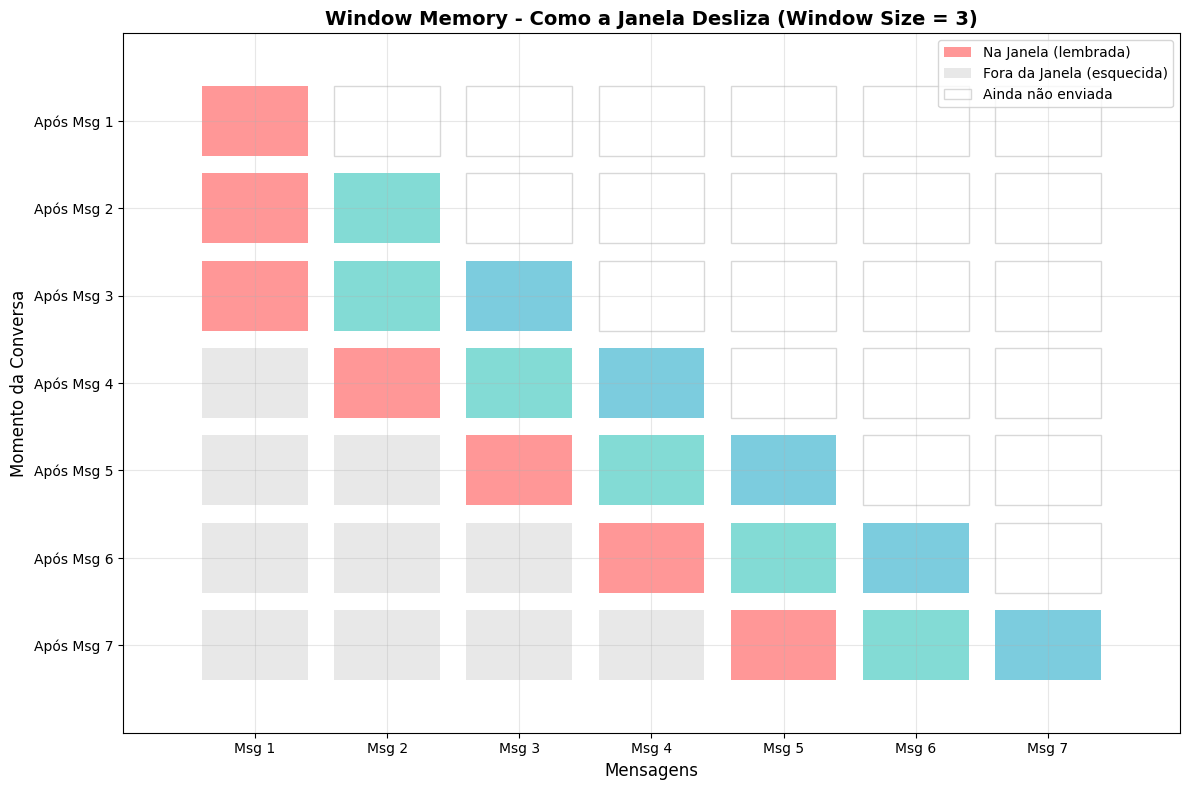

📊 Assim funciona a Window Memory! Vai deslizando e esquecendo o passado...


In [25]:
# Visualizando como a Window Memory funciona
import matplotlib.pyplot as plt
import numpy as np

# Simulando o deslizamento da janela
messages = list(range(1, 8))  # Mensagens 1 a 7
window_size = 3

fig, ax = plt.subplots(figsize=(12, 8))

# Criando visualização do deslizamento
for i, msg_num in enumerate(messages):
    # Calculando quais mensagens estão na janela
    if msg_num <= window_size:
        window_start = 1
        window_end = msg_num
    else:
        window_start = msg_num - window_size + 1
        window_end = msg_num

    # Plotando todas as mensagens
    y_pos = len(messages) - i - 1

    # Mensagens fora da janela (cinza)
    for m in range(1, window_start):
        ax.add_patch(plt.Rectangle((m-0.4, y_pos-0.4), 0.8, 0.8,
                                  facecolor='lightgray', alpha=0.5))

    # Mensagens na janela (colorido)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for j, m in enumerate(range(window_start, window_end + 1)):
        color = colors[j % len(colors)]
        ax.add_patch(plt.Rectangle((m-0.4, y_pos-0.4), 0.8, 0.8,
                                  facecolor=color, alpha=0.7))

    # Mensagens futuras (vazio)
    for m in range(window_end + 1, 8):
        ax.add_patch(plt.Rectangle((m-0.4, y_pos-0.4), 0.8, 0.8,
                                  facecolor='white', edgecolor='gray', alpha=0.3))

# Configurando o plot
ax.set_xlim(0, 8)
ax.set_ylim(-1, len(messages))
ax.set_xlabel('Mensagens', fontsize=12)
ax.set_ylabel('Momento da Conversa', fontsize=12)
ax.set_title('Window Memory - Como a Janela Desliza (Window Size = 3)', fontsize=14, fontweight='bold')

# Labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f'Msg {i}' for i in range(1, 8)])
ax.set_yticks(range(len(messages)))
ax.set_yticklabels([f'Após Msg {i+1}' for i in range(len(messages))][::-1])

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', alpha=0.7, label='Na Janela (lembrada)'),
    Patch(facecolor='lightgray', alpha=0.5, label='Fora da Janela (esquecida)'),
    Patch(facecolor='white', edgecolor='gray', alpha=0.3, label='Ainda não enviada')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Assim funciona a Window Memory! Vai deslizando e esquecendo o passado...")

## ⚖️ Comparando os Três Tipos

**Tá, mas qual usar quando?**

Cada tipo de memória tem seu lugar! Vamos fazer um comparativo prático:

| Tipo | Quando Usar | Prós | Contras |
|------|-------------|------|----------|
| **Buffer** | Conversas curtas, contexto completo necessário | Nada se perde | Pode ficar muito grande |
| **Summary** | Conversas longas, contexto geral importante | Economiza tokens | Pode perder detalhes |
| **Window** | Contexto recente é o que importa | Tamanho previsível | Esquece o passado |

### Fórmula de Escolha:

$$\text{Memory Type} = \begin{cases}
\text{Buffer} & \text{se } \text{conversa} < 10 \text{ interações} \\
\text{Summary} & \text{se } \text{contexto histórico importante} \\
\text{Window} & \text{se } \text{só contexto recente importa}
\end{cases}$$

**Dica!** Na dúvida, comece com Buffer pra conversas simples e Window pra chatbots!

In [26]:
# Vamos fazer um teste comparativo lado a lado!
from langchain.memory import ConversationBufferMemory, ConversationBufferWindowMemory
from langchain.chains import ConversationChain

# Criando três chains diferentes
buffer_mem = ConversationBufferMemory()
window_mem = ConversationBufferWindowMemory(k=2)  # Janela pequena pra ver diferença

buffer_chain = ConversationChain(llm=model, memory=buffer_mem, verbose=False)
window_chain = ConversationChain(llm=model, memory=window_mem, verbose=False)

# Teste com sequência de mensagens
test_sequence = [
    "Meu nome é Ana",
    "Tenho 28 anos",
    "Moro em Brasília",
    "Trabalho como engenheira",
    "Qual meu nome e idade?"
]

print("🥊 BATTLE ROYALE - Buffer vs Window!")
print("=" * 60)

buffer_responses = []
window_responses = []

for i, msg in enumerate(test_sequence):
    print(f"\n📩 Mensagem {i+1}: {msg}")

    # Testando Buffer
    buffer_response = buffer_chain.predict(input=msg)
    buffer_responses.append(buffer_response)

    # Testando Window
    window_response = window_chain.predict(input=msg)
    window_responses.append(window_response)

    print(f"\n🧠 Buffer: {buffer_response[:100]}...")
    print(f"🪟 Window: {window_response[:100]}...")

    # Mostrando tamanho da memória
    buffer_size = len(buffer_mem.buffer)
    window_vars = window_mem.load_memory_variables({})
    window_size = len(str(window_vars['history']))

    print(f"📊 Tamanhos - Buffer: {buffer_size}, Window: {window_size}")

print("\n🏆 Resultado: Ambos têm seus méritos! Depende do caso de uso.")

🥊 BATTLE ROYALE - Buffer vs Window!

📩 Mensagem 1: Meu nome é Ana

🧠 Buffer: Olá Ana! É um prazer conhecê-la. Meu nome é Bard, e sou um modelo de linguagem grande do Google AI. ...
🪟 Window: Olá Ana! É um prazer conhecê-la. My name is Gemini, and I'm a large language model. I'm trained on a...
📊 Tamanhos - Buffer: 231, Window: 446

📩 Mensagem 2: Tenho 28 anos

🧠 Buffer: Que bom! 28 anos é uma idade ótima. Você está em uma fase da vida com muitas possibilidades e oportu...
🪟 Window: Que bom saber, Ana! 28 anos! That's a great age. Are you doing anything special to celebrate this ye...
📊 Tamanhos - Buffer: 731, Window: 910

📩 Mensagem 3: Moro em Brasília

🧠 Buffer: Brasília! Uma cidade fascinante, planejada e com uma arquitetura única. Tenho muitas informações sob...
🪟 Window: Brasília! Que interessante! I've processed a lot of information about Brasília. It's a fascinating c...
📊 Tamanhos - Buffer: 1579, Window: 1344

📩 Mensagem 4: Trabalho como engenheira

🧠 Buffer: Engenheira! Que leg

## 🔧 Memory Systems Customizadas

**E se eu quiser criar minha própria memória?**

Claro que dá! O LangChain é super flexível. Você pode:

1. **Customizar prompts das memórias**
2. **Combinar diferentes tipos**
3. **Adicionar filtros e regras**
4. **Integrar com bancos de dados**

### Exemplo Prático: Memória com Filtro de Importância

Vamos criar uma memória que só guarda informações "importantes"!

**Dica!** Isso vai ser útil quando chegarmos no módulo de RAG - você vai querer filtrar o que vale a pena lembrar!

In [29]:
# Criando uma memória customizada com filtro de importância
from langchain.schema import BaseMessage
from langchain.memory.chat_message_histories import ChatMessageHistory

# Palavras-chave que consideramos "importantes"
important_keywords = [
    'nome', 'idade', 'trabalho', 'profissão', 'empresa', 'projeto',
    'problema', 'erro', 'help', 'ajuda', 'importante', 'urgente'
]

def is_important_message(message_text):
    """Verifica se uma mensagem contém informações importantes"""
    message_lower = message_text.lower()
    return any(keyword in message_lower for keyword in important_keywords)

# Memória customizada que filtra por importância
class FilteredMemory(ConversationBufferMemory):
    def save_context(self, inputs, outputs):
        """Salva apenas contextos importantes"""
        input_text = inputs.get('input', '')
        output_text = outputs.get('output', '')

        # Verifica se é importante
        if is_important_message(input_text) or is_important_message(output_text):
            print(f"🎯 Mensagem importante detectada! Salvando...")
            super().save_context(inputs, outputs)
        else:
            print(f"😐 Mensagem comum, não salvando...")

# Testando nossa memória customizada
filtered_memory = FilteredMemory()
filtered_chain = ConversationChain(llm=model, memory=filtered_memory, verbose=False)

print("🎛️ Memória customizada criada! Vamos testar o filtro...")

test_messages = [
    "Oi, como você está?",  # Comum
    "Meu nome é Roberto",   # Importante (nome)
    "Que dia bonito hoje",  # Comum
    "Trabalho na Google",   # Importante (trabalho)
    "Gosto de café",        # Comum
    "Preciso de ajuda com Python"  # Importante (ajuda)
]

for i, msg in enumerate(test_messages):
    print(f"\n--- Teste {i+1} ---")
    print(f"Mensagem: {msg}")
    response = filtered_chain.predict(input=msg)

print(f"\n📋 Memória final (só o importante):")
print(filtered_memory.buffer)

🎛️ Memória customizada criada! Vamos testar o filtro...

--- Teste 1 ---
Mensagem: Oi, como você está?
😐 Mensagem comum, não salvando...

--- Teste 2 ---
Mensagem: Meu nome é Roberto
🎯 Mensagem importante detectada! Salvando...

--- Teste 3 ---
Mensagem: Que dia bonito hoje
😐 Mensagem comum, não salvando...

--- Teste 4 ---
Mensagem: Trabalho na Google
🎯 Mensagem importante detectada! Salvando...

--- Teste 5 ---
Mensagem: Gosto de café
😐 Mensagem comum, não salvando...

--- Teste 6 ---
Mensagem: Preciso de ajuda com Python
🎯 Mensagem importante detectada! Salvando...

📋 Memória final (só o importante):
Human: Meu nome é Roberto
AI: Olá, Roberto! É um prazer conhecê-lo. Meu nome é... bem, eu não tenho um nome como os humanos têm. Você pode me chamar de AI. Fui treinado em uma vasta quantidade de texto e código pelo Google. Estou aqui para ajudar com informações, responder a perguntas e até mesmo conversar um pouco. O que posso fazer por você hoje, Roberto?
Human: Trabalho na Google
AI:

## 🚀 Integrando Memory com Chains Avançadas

**Lembra das Chains do módulo 6?** Agora vamos turbinar elas com memória!

Podemos combinar:
- ✅ **PromptTemplate** (módulo 4) + Memory
- ✅ **OutputParser** (módulo 5) + Memory  
- ✅ **Chains customizadas** (módulo 6) + Memory

Isso vai ser a base pro RAG que vamos ver no módulo 10!

**Dica!** Memory + Chains é a combinação perfeita pra criar chatbots inteligentes!

In [30]:
# Combinando Memory com PromptTemplate e OutputParser
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.schema import OutputParserException
from pydantic import BaseModel, Field
from typing import List

# Modelo pra estruturar as respostas (do módulo 5)
class UserInfo(BaseModel):
    name: str = Field(description="Nome do usuário")
    interests: List[str] = Field(description="Lista de interesses mencionados")
    questions: List[str] = Field(description="Perguntas feitas pelo usuário")

# Parser estruturado
parser = PydanticOutputParser(pydantic_object=UserInfo)

# Prompt customizado que usa memória
prompt = PromptTemplate(
    template="""Você é um assistente que coleta informações sobre usuários.

Histórico da conversa:
{history}

Pergunta atual: {input}

Com base no histórico e pergunta atual, extraia:
1. Nome do usuário (se mencionado)
2. Interesses mencionados
3. Perguntas feitas

{format_instructions}

Se alguma informação não foi mencionada, use valores padrão apropriados.""",
    input_variables=["history", "input"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

# Memória pra nossa chain avançada
advanced_memory = ConversationBufferMemory(memory_key="history")

# Chain avançada (do módulo 6 + memória)
advanced_chain = ConversationChain(
    llm=model,
    prompt=prompt,
    memory=advanced_memory,
    verbose=True
)

print("🚀 Chain avançada com memória criada! Testando...")

# Testando a chain avançada
test_inputs = [
    "Oi! Sou Lucas e adoro programação",
    "Também gosto muito de machine learning",
    "Como posso aprender mais sobre IA?"
]

for i, user_input in enumerate(test_inputs):
    print(f"\n🔄 Teste {i+1}: {user_input}")
    try:
        response = advanced_chain.predict(input=user_input)
        print(f"Raw response: {response[:200]}...")

        # Tentando parsear a resposta
        # parsed_info = parser.parse(response)
        # print(f"✅ Info estruturada: {parsed_info}")
    except Exception as e:
        print(f"❌ Erro no parsing: {e}")
        print(f"Resposta bruta: {response}")

🚀 Chain avançada com memória criada! Testando...

🔄 Teste 1: Oi! Sou Lucas e adoro programação


> Entering new ConversationChain chain...
Prompt after formatting:
Você é um assistente que coleta informações sobre usuários.
    
Histórico da conversa:


Pergunta atual: Oi! Sou Lucas e adoro programação

Com base no histórico e pergunta atual, extraia:
1. Nome do usuário (se mencionado)
2. Interesses mencionados
3. Perguntas feitas

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"name": {"description": "Nome do usuário", "title": "Name", "type": "string"}, "interests": {"des

## 📊 Exercício Prático - Sistema de Atendimento

**Bora colocar a mão na massa!** 🔥

Vamos criar um sistema de atendimento ao cliente que:
1. Lembra do histórico da conversa
2. Identifica o tipo de problema
3. Oferece soluções personalizadas
4. Usa diferentes tipos de memória

**Seu desafio:**
- Escolha o tipo de memória mais adequado
- Crie prompts eficazes
- Teste com casos reais

**Dica!** Pense em como isso vai ajudar quando criarmos RAG com documentos de help!

In [ ]:
# EXERCÍCIO: Sistema de Atendimento com Memory
# Sua missão: completar este sistema!

from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferWindowMemory  # Você pode mudar!

# 1. Escolha o tipo de memória (complete aqui)
# TODO: Experimente diferentes tipos e veja qual funciona melhor
customer_memory = ConversationBufferWindowMemory(
    k=5,  # Ajuste este número!
    memory_key="chat_history"
)

# 2. Crie um prompt para atendimento (complete aqui)
customer_service_prompt = PromptTemplate(
    template="""Você é um atendente virtual experiente e empático.

Histórico da conversa:
{chat_history}

Cliente: {input}

Instruções:
- Seja sempre educado e prestativo
- Use informações do histórico para personalizar respostas
- Identifique o tipo de problema (técnico, comercial, dúvida)
- Ofereça soluções práticas
- Se não souber algo, seja honesto

Resposta:""",
    input_variables=["chat_history", "input"]
)

# 3. Crie a chain de atendimento
customer_service_chain = ConversationChain(
    llm=model,
    prompt=customer_service_prompt,
    memory=customer_memory,
    verbose=False
)

print("🎧 Sistema de Atendimento Online! Como posso ajudar?")

# 4. Simule uma conversa de atendimento
customer_conversation = [
    "Oi, estou com problema no meu pedido",
    "Meu nome é Sandra Silva, CPF 123.456.789-00",
    "Comprei um notebook mas não chegou ainda",
    "O pedido foi feito há 15 dias, número #12345",
    "Preciso do notebook urgente para trabalhar",
    "Vocês podem me dar uma previsão?"
]

for i, message in enumerate(customer_conversation):
    print(f"\n👤 Cliente: {message}")
    response = customer_service_chain.predict(input=message)
    print(f"🎧 Atendente: {response}")
    print("-" * 50)

print("\n✅ Conversação finalizada!")

# DESAFIO EXTRA: Modifique o código acima para:
# - Usar ConversationSummaryMemory
# - Adicionar categorização automática de problemas
# - Incluir um sistema de escalação para problemas complexos

## 🔗 Preparando para o RAG (Módulo 10)

**Tá, mas como Memory se conecta com RAG?**

Ótima pergunta! No RAG (Retrieval-Augmented Generation) que vamos ver no módulo 10, a memória é FUNDAMENTAL:

### RAG + Memory = 🚀

1. **Contexto de Consultas** → Memória lembra o que o usuário já perguntou
2. **Refinamento de Busca** → Usa histórico pra melhorar retrieval
3. **Conversas Longas** → Mantém contexto em documentos grandes
4. **Personalização** → Adapta respostas baseado no histórico

### Pipeline RAG + Memory:

```
Pergunta + Histórico → Busca Documentos → Gera Resposta → Atualiza Memória
```

**Próximos módulos:**
- **Módulo 8:** Document Loading (pra alimentar o RAG)
- **Módulo 9:** Vector Stores (pra buscar documentos)
- **Módulo 10:** RAG completo com memória!

**Dica!** A memória que você aprendeu hoje vai ser a base pra criar chatbots que conversam sobre documentos!

In [31]:
from langchain.memory import ConversationBufferMemory

# ✅ Função que simula RAG + Memory sem usar chains complexas
def rag_with_memory(query, retrieved_info):
    # Buscar histórico da memória
    history = rag_memory.chat_memory.messages
    history_text = "\n".join([f"{msg.type}: {msg.content}" for msg in history])

    # Criar prompt completo
    full_prompt = rag_prompt.format(
        history=history_text,
        retrieved_info=retrieved_info,
        input=query
    )

    # Obter resposta
    response = model.invoke(full_prompt)

    # Salvar na memória
    rag_memory.save_context({"input": query}, {"output": response.content})

    return response.content

print("🔮 Preview: RAG + Memory em ação!")

# Simulando consultas com retrieval + memory
rag_queries = [
    "O que é Python?",
    "E machine learning?",
    "Qual a diferença entre Python e ML que você mencionou?"
]

for query in rag_queries:
    # Simular retrieval
    retrieved = simple_retrieval(query)

    print(f"\n�� Pergunta: {query}")
    print(f"�� Retrieved: {retrieved}")

    # ✅ Usar a função personalizada
    response = rag_with_memory(query, retrieved)
    print(f"�� Resposta: {response}")
    print("-" * 60)

print("\n🚀 Isso é só um preview! No módulo 10 vamos fazer RAG completo com vector stores!")

🔮 Preview: RAG + Memory em ação!

�� Pergunta: O que é Python?
�� Retrieved: Python é uma linguagem de programação versátil e fácil de aprender.
�� Resposta: Já conversamos sobre isso antes! Python é uma linguagem de programação versátil e fácil de aprender. É a ferramenta que você usa para escrever instruções para o computador.
------------------------------------------------------------

�� Pergunta: E machine learning?
�� Retrieved: ML é um subcampo da IA que permite sistemas aprenderem automaticamente.
�� Resposta: Já conversamos sobre Machine Learning antes! Para recapitular, Machine Learning (ML) é um subcampo da Inteligência Artificial (IA) que permite que os sistemas aprendam automaticamente a partir de dados, sem serem explicitamente programados para cada tarefa. Python, como já mencionamos, é frequentemente usado em ML como ferramenta para implementar algoritmos e modelos.
------------------------------------------------------------

�� Pergunta: Qual a diferença entre Python

## 🎯 Exercício Final - Desafio Completo

**Hora do desafio final!** 🏆

Crie um **Personal Assistant** que:

1. **Lembra informações pessoais** (nome, preferências, etc.)
2. **Adapta respostas baseado no histórico**
3. **Usa diferentes tipos de memória conforme necessário**
4. **Integra com prompts customizados**

**Requisitos:**
- [ ] Use pelo menos 2 tipos de memória diferentes
- [ ] Crie prompts personalizados
- [ ] Implemente filtros de importância
- [ ] Teste com conversas longas

**Dica!** Este exercício vai preparar você pra criar assistentes mais complexos nos próximos módulos!

In [ ]:
# DESAFIO FINAL: Personal Assistant com Memory Systems
# Complete este código criando um assistente pessoal completo!

print("🤖 DESAFIO: Personal Assistant com Memory Systems")
print("=" * 60)
print("Sua missão: Completar este assistente pessoal inteligente!\n")

# TODO 1: Escolha e configure diferentes tipos de memória
# Dica: Use Buffer para info pessoal e Window para conversas casuais

personal_info_memory = None  # Configure aqui!
conversation_memory = None   # Configure aqui!

# TODO 2: Crie prompts customizados
# Dica: Um prompt pra capturar info pessoal, outro pra conversa geral

personal_prompt = None  # Configure aqui!
general_prompt = None   # Configure aqui!

# TODO 3: Implemente lógica de decisão
# Quando usar cada tipo de memória/prompt?

def choose_memory_type(user_input):
    """Decide qual tipo de memória usar baseado na entrada"""
    # TODO: Implementar lógica aqui
    pass

# TODO 4: Crie o assistente completo
class PersonalAssistant:
    def __init__(self):
        # TODO: Inicializar chains, memórias, etc.
        pass

    def process_message(self, message):
        """Processa mensagem escolhendo memória e prompt adequados"""
        # TODO: Implementar lógica completa
        pass

# TODO 5: Teste seu assistente
test_conversation = [
    "Oi! Meu nome é Alex",
    "Trabalho como designer",
    "Gosto muito de café pela manhã",
    "Como está o tempo hoje?",
    "Você lembra qual é minha profissão?",
    "E o que eu gosto de beber de manhã?"
]

print("🧪 Testando seu assistente...")
print("Implemente o código acima e descomente os testes!\n")

# assistant = PersonalAssistant()
# for msg in test_conversation:
#     print(f"Você: {msg}")
#     response = assistant.process_message(msg)
#     print(f"Assistant: {response}\n")

print("💡 Dicas para implementar:")
print("- Use ConversationBufferMemory para info pessoal")
print("- Use ConversationBufferWindowMemory para conversas casuais")
print("- Crie prompts que referenciam o tipo de informação")
print("- Implemente keywords para decidir qual chain usar")
print("\n🚀 Boa sorte! Este exercício vai te preparar para os próximos módulos!")

## 🎉 Resumo do Módulo - O que Aprendemos

**Liiindo! Chegamos ao final!** 🚀

### ✅ O que você domina agora:

1. **Por que precisamos de memória** → LLMs são stateless
2. **ConversationBufferMemory** → Guarda tudo, boa pra conversas curtas
3. **ConversationSummaryMemory** → Resume conversas, economiza tokens
4. **ConversationBufferWindowMemory** → Janela deslizante, foco no recente
5. **Memory customizada** → Filtros e regras personalizadas
6. **Integração com Chains** → Combinando com prompts e parsers
7. **Preview do RAG** → Como memória vai ser crucial

### 🔗 Conectando com outros módulos:

- **Módulos 1-6** → Base sólida pra usar memory
- **Módulo 8-10** → Document Loading, Vector Stores e RAG
- **Módulo 11** → Agents vão usar memory pra ser mais inteligentes

### 🎯 Próximos passos:

No **módulo 8** vamos aprender **Document Loading** - como carregar e processar documentos pra alimentar nossos sistemas de IA. A memória que você aprendeu hoje vai ser fundamental pra criar conversas sobre documentos!

**Dica!** Pratique criando diferentes tipos de chatbots com memory. Vai te ajudar muito nos próximos módulos!

**Bora pro próximo módulo?** 🔥

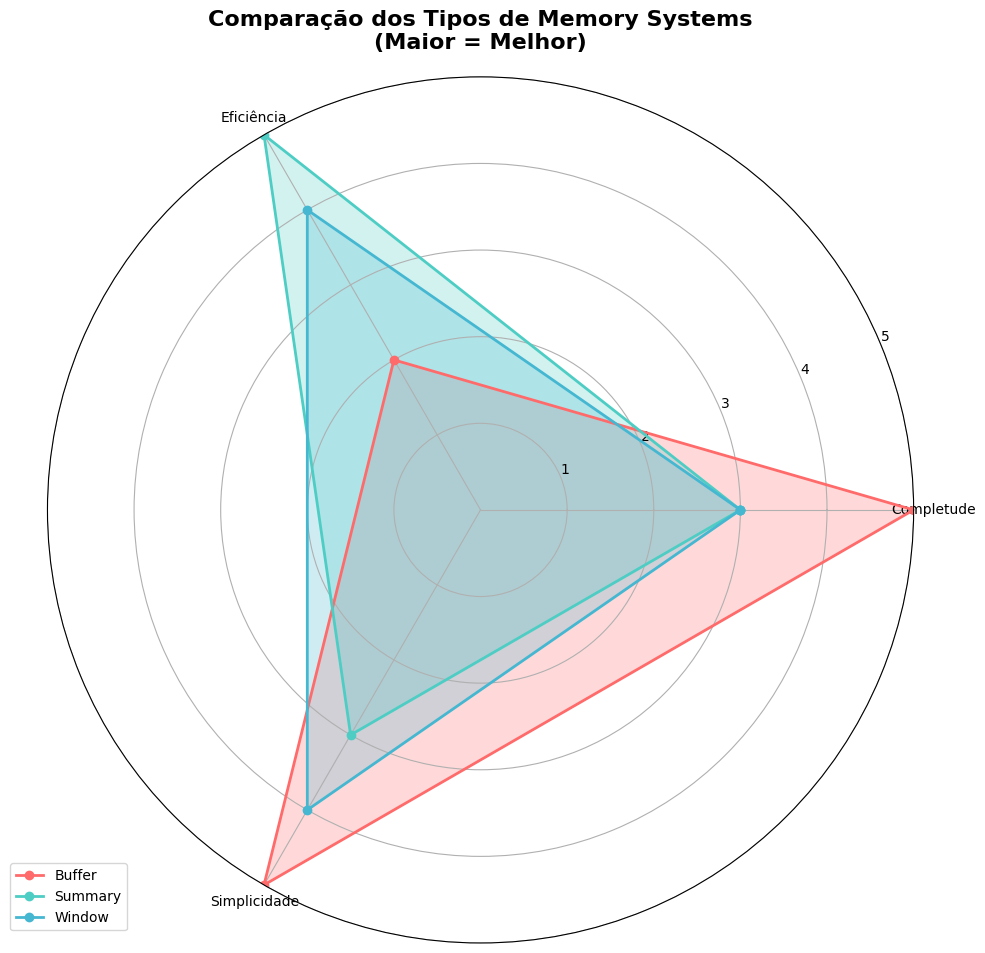

📊 Resumo Visual Completo!

🎓 Você agora domina Memory Systems no LangChain!

🚀 Próximo módulo: Document Loading e Splitters
   Vamos aprender a carregar e processar documentos!

💪 Continue praticando e nos vemos no próximo módulo!


In [32]:
# Visualização final - Resumo dos tipos de Memory
import matplotlib.pyplot as plt
import numpy as np

# Dados para comparação final
memory_types = ['Buffer', 'Summary', 'Window']
metrics = ['Completude', 'Eficiência', 'Simplicidade']

# Scores de 0 a 5 para cada métrica
scores = {
    'Buffer': [5, 2, 5],    # Completa, pouco eficiente, muito simples
    'Summary': [3, 5, 3],   # Moderada, muito eficiente, moderada
    'Window': [3, 4, 4]     # Moderada, eficiente, simples
}

# Criando gráfico radar
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Ângulos para cada métrica
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Fechar o círculo

# Cores para cada tipo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Plotar cada tipo de memória
for i, (memory_type, color) in enumerate(zip(memory_types, colors)):
    values = scores[memory_type] + scores[memory_type][:1]  # Fechar o círculo
    ax.plot(angles, values, 'o-', linewidth=2, label=memory_type, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Configurar gráfico
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_title('Comparação dos Tipos de Memory Systems\n(Maior = Melhor)',
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.grid(True)

plt.tight_layout()
plt.show()

print("📊 Resumo Visual Completo!")
print("\n🎓 Você agora domina Memory Systems no LangChain!")
print("\n🚀 Próximo módulo: Document Loading e Splitters")
print("   Vamos aprender a carregar e processar documentos!")
print("\n💪 Continue praticando e nos vemos no próximo módulo!")